<a href="https://colab.research.google.com/github/SebastianMM-96/fake-news/blob/main/fake-news/fake-news-models/fake_news_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <a id="top_section"></a>
# Detección de noticias falsas implementando algoritmos de aprendizaje automatico
#### Desarrollado por: Sebastián Marroquín

***

#### Tabla de contenidos

* [Importacion de librerías](#parte1)
* [Conjunto de datos](#parte2)
* [Análisis Exploratorio de datos](#parte3)
* [Preprocesamiento de datos](#parte4)
* [Visualización](#parte5)
* [Vectorización](#parte6)
* [Definición de subconjuntos](#parte7)
* [Modelos de aprendizaje automatico](#parte8)
* [Descarga de modelos](#parte9)
* [Comparación de modelos](#parte10)

***

<a id='parte1'></a>
# 1. Librerías

In [1]:
# Librerías básicas
import numpy as np 
import pandas as pd
import nltk
import re
import pickle
import itertools

# Herramienta de NLTK
from nltk import tokenize

# Importando Gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# Graficación
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Scikit-learn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

# Vectorización
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Pipeline
from sklearn.pipeline import Pipeline

# Clasificadores del aprendizaje supervisado
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier

# Clasificadores del aprendizaje no supervisado
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Advertencias
import warnings
warnings.filterwarnings('ignore')

<a id='parte2'></a>
# 2. Importando el conjunto de datos

El conjunto de datos que utilizaremos para llevar a cabo el clasificador de noticias fue recopilado desde [Kaggle](https://www.kaggle.com/), especificamente el conjunto de datos que se encuentra disponible en este [link](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset).

![Kaggle](https://inlab.fib.upc.edu/sites/default/files/styles/large/public/field/image/captura_3.png)

Este conjunto de datos consta de dos archivos de tipo CSV, los cuales contienen tipos de noticias reales y noticias falsas respectivamente. Como veremos a continuación, los conjuntos de datos contienen diferentes tipos de artículos sobre diferentes temas, sin embargo, la mayoría de estos artículos se enfocan en temas como *politíca* ó *noticias mundiales*. 

Cada artículo contiene los siguientes campos:



*   Título del artículo
*   Texto
*   Tipo de noticia
*   Fecha de publicación del artículo

Cabe resaltar que este conjunto de datos solo contiene artículos que datan del año 2016 al 2017. 




In [2]:
fake_df = pd.read_csv('/content/drive/MyDrive/fake-news-datasets/Kaggle/Fake.csv')
true_df = pd.read_csv('/content/drive/MyDrive/fake-news-datasets/Kaggle/True.csv')

## 2.1 Información de los conjuntos de datos

In [3]:
true_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [4]:
fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


## 2.2 Inspeccionando el conjunto de datos

Echaremos un vistazo a como es que están formados nuestros conjuntos de datos que han sido guardados en las variables declaradas.

In [5]:
print('Forma del conjunto de noticias reales: {}'.format(true_df.shape))

Forma del conjunto de noticias reales: (21417, 4)


In [6]:
print('Forma del conjunto de noticias falsas: {}'.format(fake_df.shape))

Forma del conjunto de noticias falsas: (23481, 4)


Mostraremos algunos datos de nuestros conjuntos de datos

In [7]:
true_df.head(5)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [8]:
fake_df.head(5)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


Calcularemos ahora el número total de noticias (reales ó falsas) de cada uno de los conjuntos de datos que hemos almacenado. 

In [9]:
print('Número de noticias reales: {}'.format(len(true_df)))
print('Número de noticias falsas: {}'.format(len(fake_df)))

Número de noticias reales: 21417
Número de noticias falsas: 23481


Como sabemos, el número de artículos que contiene el archivo *True.csv* es de 21,417, mientras que el archivo de *Fake.csv* contiene un total de 23,481 artículos. 

In [10]:
ratio = round(len(fake_df) / (len(true_df) + len(fake_df)), 2)
ratio = round(ratio * 100, 2)
print('Porcentaje de noticias falsas: {}%'.format(ratio))

Porcentaje de noticias falsas: 52.0%


Verificaremos la integridad de los datos, esto si es que dentro de uno de nuestros conjuntos de datos existen valores que puedan estar perdidos ó que sean nulos. 

In [11]:
true_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [12]:
fake_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

De lo obtenido, sabemos que los datos se encuentran en buen estado, por lo que podemos continuar.

<a id='parte3'></a>
# 3. EDA

Añadiremos a nuestro conjunto de datos una columna extra para identificar si la noticia es falsa o es real. A este proceso se le llama *etiquetado*. 

In [13]:
true_df['label'] = 1
true_df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [14]:
true_df.text[0]

'WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support educat

In [15]:
fake_df['label'] = 0
fake_df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [16]:
fake_df.text[0]

'Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t ev

Ahora, no queremos trabajar con dos variables que almacenen nuestros datos, por lo que concatenaremos nuestros dos conjuntos de datos en una sola variable, esto lo podemos hacer utilizando el método de *concat* que nos ofrece *Pandas*. 

Por lo que ahora tendremos una sola variable que almacenará todos nuestros datos. 

In [17]:
data = pd.concat([true_df, fake_df]).reset_index(drop = True)

Ahora nuestra variable se ve de la siguiente forma:

In [18]:
data.sample(10)

,title,text,subject,date,label
31478,“DIRTY JOBS” HOST MIKE ROWE Absolutely Destroy...,Dirty Jobs host Mike Rowe went off on a guy ...,politics,"Aug 23, 2017",0
25223,Know-Nothing Trump Reverses Yet ANOTHER Posit...,Donald Trump spent months on the campaign trai...,News,"November 14, 2016",0
27897,WATCH: Sarah Palin Was Just Asked If She’ll B...,Just when we thought that Sarah Palin was out ...,News,"May 8, 2016",0
18223,Cyprus says it agrees with Spain to postpone s...,NICOSIA (Reuters) - Cyprus said on Thursday it...,worldnews,"October 5, 2017",1
32161,NANCY PELOSI GIGGLES LIKE A CHILD: Says It’s H...,Nancy Pelosi couldn t sink any lower than this...,politics,"May 30, 2017",0
33187,TUCKER CARLSON Rips Into Pro-Refugee Leader: “...,For More On HIAS: Refugee Resettlement Watch,politics,"Jan 31, 2017",0
32117,“CHICKEN LITTLE” AL GORE Uses Fear and the Bib...,Former VP Al Gore told ABC s George Stephanopo...,politics,"Jun 4, 2017",0
36772,"SHERIFFS, LT. GOV AND IMMIGRATION EXPERTS FIGH...","Hello America Are we awake yet?AUSTIN, Texas ...",politics,"Aug 7, 2015",0
16584,German parties in coalition talks agree on no ...,BERLIN (Reuters) - Politicians from four Germa...,worldnews,"October 24, 2017",1
30589,JUST IN: Fusion GPS Sued By 3 Billionaires Ove...,ACTIONS HAVE CONSEQUENCES:Three Russian billio...,politics,"Dec 17, 2017",0


De nuestro nuevo conjunto de datos, existe una columna que no utilizaremos, por lo que está será eliminada del conjunto. 

In [19]:
data.drop(columns = ['date'], inplace = True)

Ahora combinaremos el texto de la noticia con el título y lo almacenaremos dentro de una columna nueva, esto para tener la estructura original de la noticia y no tenerla separada

In [20]:
data['originalNews'] = data['title'] + '' + data['text']

In [21]:
data.head()

,title,text,subject,label,originalNews
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...


Ahora mostraremos el resultado de la columna que acabamos de crear, la cual contendrá el título y el cuerpo de la misma noticia. 

In [22]:
data['originalNews'][0]

'As U.S. budget fight looms, Republicans flip their fiscal scriptWASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-

<a id='parte4'></a>
# 4. Pre-procesamiento de datos

In [23]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [24]:
from nltk.corpus import stopwords

stopwords_ = stopwords.words('english')
stopwords_.extend(['from', 'subject', 're', 'edu', 'use'])

De nuestro conjunto de datos eliminaremos algunas palabras que tienen almenos 2 o menos carácteres. 

In [25]:
def textPreprocess(text):
  res = []
  for token in gensim.utils.simple_preprocess(text):
    if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stopwords_:
      res.append(token)
  
  return res

Es momento de aplicar la función y ver el comportamiento que generará en nuestro conjunto de datos. Para ello, guardaremos en una columna el valor que nos generará la salida de nuestra función.

In [26]:
data['cleaned'] = data['originalNews'].apply(textPreprocess)

Mostraremos ahora una noticia en particular para ver como es que ha afectado

In [27]:
data['originalNews'][0]

'As U.S. budget fight looms, Republicans flip their fiscal scriptWASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-

In [28]:
data.head()

,title,text,subject,label,originalNews,cleaned
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon..."


Obtendremos el total de las palabras que existen dentro de nuestro conjunto de datos, y para ello lo obtendremos con una función

In [29]:
listOfWords = []
for index in data.cleaned:
  for aux in index:
    listOfWords.append(aux)

Mostraremos ahora el arreglo que almacena la lista de palabras que acabamos de obtener de nuestra columna de datos. 

In [30]:
print("Longitud de la lista de palabras: {}".format(len(listOfWords)))

Longitud de la lista de palabras: 9252557


Ahora obtendremos el total de palabras que son únicas dentro de nuestro conjunto de datos

In [31]:
totalWords = len(list(set(listOfWords)))
# Mostraremos el total de palabras
totalWords

122996

Uniremos ahora las palabras que acabamos de obtener en un solo *string*

In [32]:
data['cleanedJoined'] = data['cleaned'].apply(lambda x : " ".join(x))
data.head()

,title,text,subject,label,originalNews,cleaned,cleanedJoined
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc...",budget fight looms republicans flip fiscal reu...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond...",military accept transgender recruits monday re...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing...",senior republican senator mueller washington r...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ...",russia probe helped australian diplomat nytwas...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon...",trump wants postal service charge amazon washi...


In [33]:
data['cleanedJoined'][0]

'budget fight looms republicans flip fiscal reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats saying need government raise percent fiscal con

In [34]:
data['length'] = data['originalNews'].apply(len)

<a id='parte5'></a>
# 5. Visualización del conjunto de datos

## 5.1 Grafica por tipo de noticias

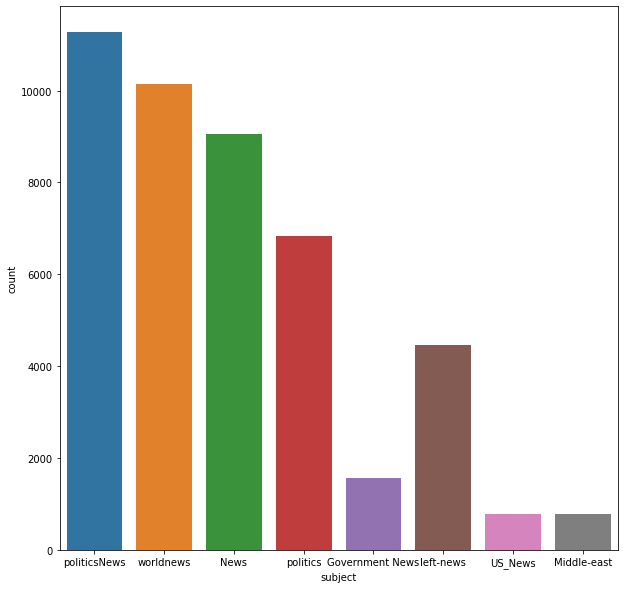

In [35]:
plt.figure(figsize=(10, 10))
sns.countplot(x = 'subject', data = data)

## 5.2 Grafica para el total de noticias

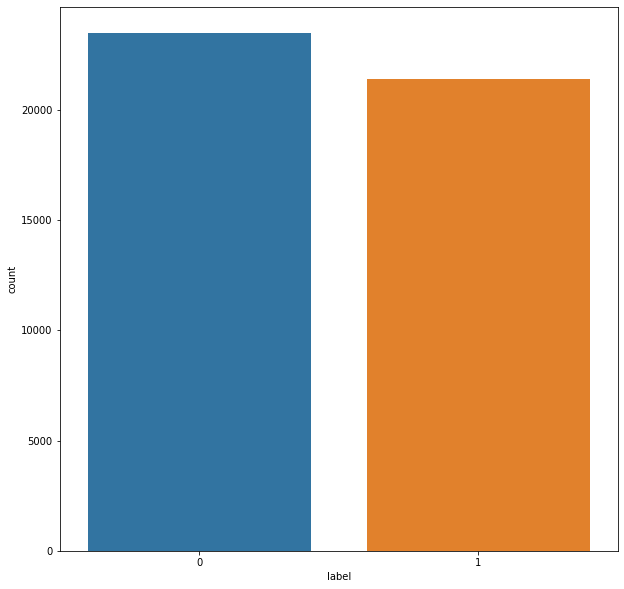

In [36]:
plt.figure(figsize=(10, 10))
sns.countplot(x = 'label', data = data)

## 5.3 Longitud de las noticias

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f40686b14d0>,
      dtype=object)

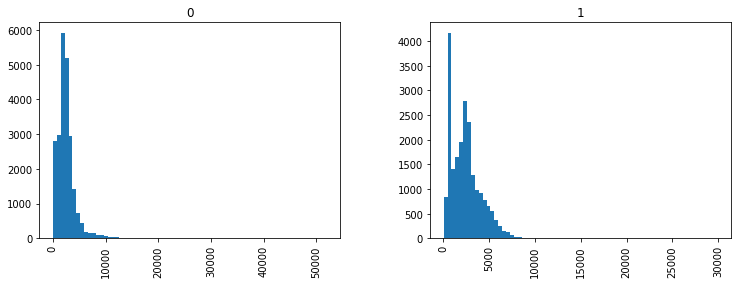

In [37]:
data.hist(
    column = 'length',
    by = 'label',
    bins = 70,
    figsize=(12, 4)
)

## 5.4 WordCloud

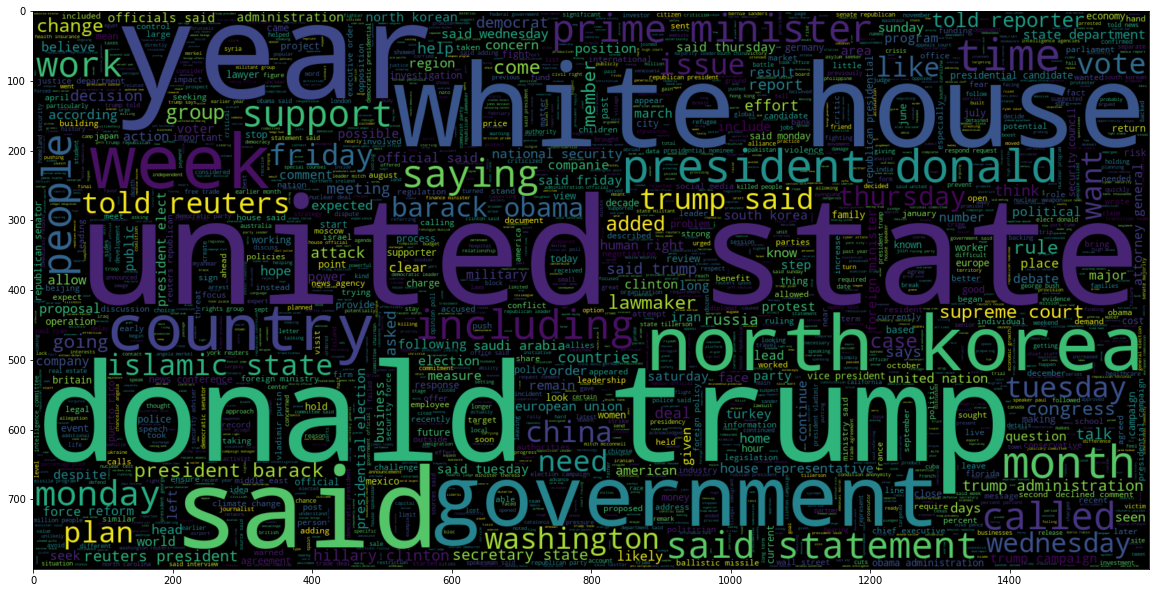

In [38]:
plt.figure(figsize= (20,20))
wordCloud = WordCloud(max_words=2000, width=1600, height=800, 
                      stopwords=stopwords_).generate(" ".join(data[data.label == 1].cleanedJoined))

plt.imshow(wordCloud, interpolation='bilinear')

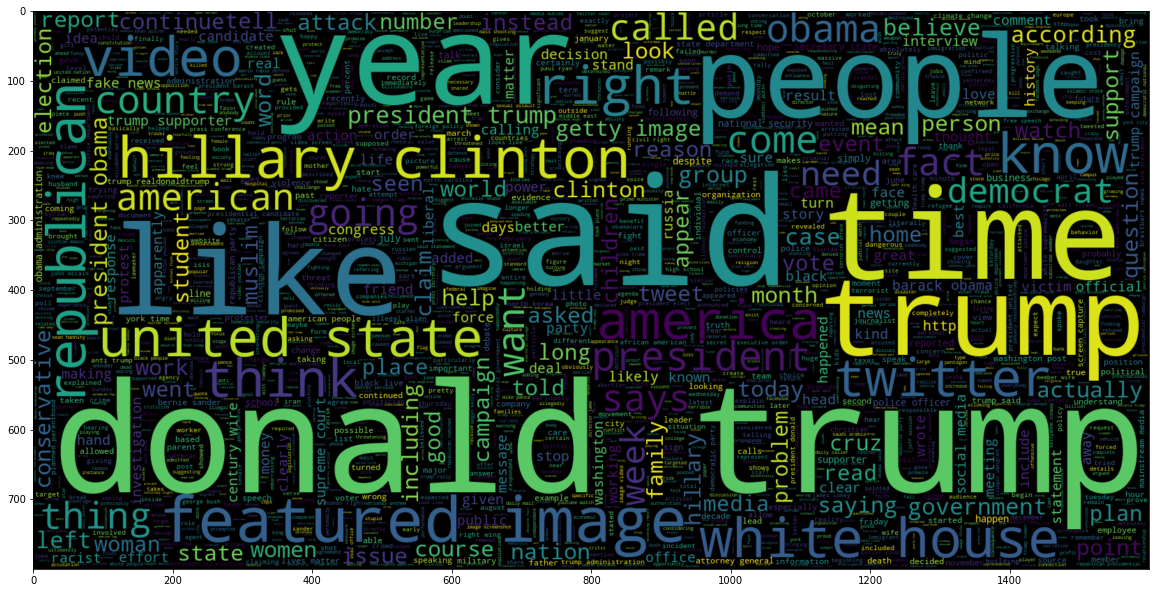

In [39]:
plt.figure(figsize= (20,20))
wordCloud = WordCloud(max_words=2000, width=1600, height=800, 
                      stopwords=stopwords_).generate(" ".join(data[data.label == 0].cleanedJoined))

plt.imshow(wordCloud, interpolation='bilinear')

## 5.5 Palabras más frecuentes (visualización)

In [40]:
token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

### 5.5.1 Palabras más frecuentes dentro de las noticias reales


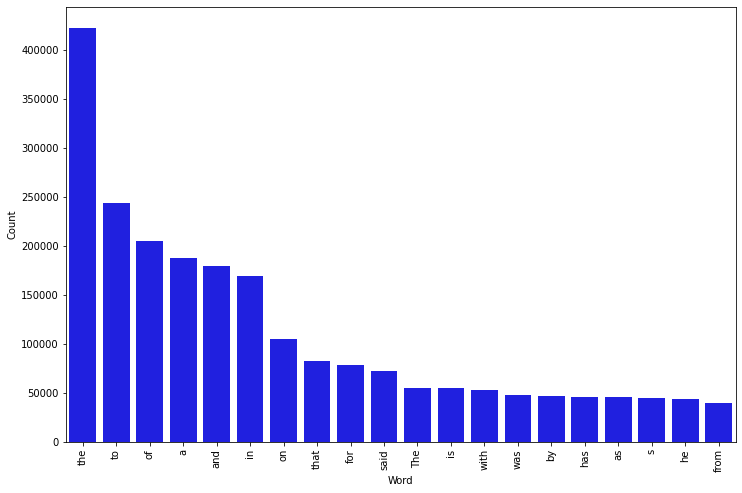

In [41]:
counter(data[data["label"] == 1], 'text', 20)

### 5.5.2 Palabras más frecuentes dentro de las noticias falsas

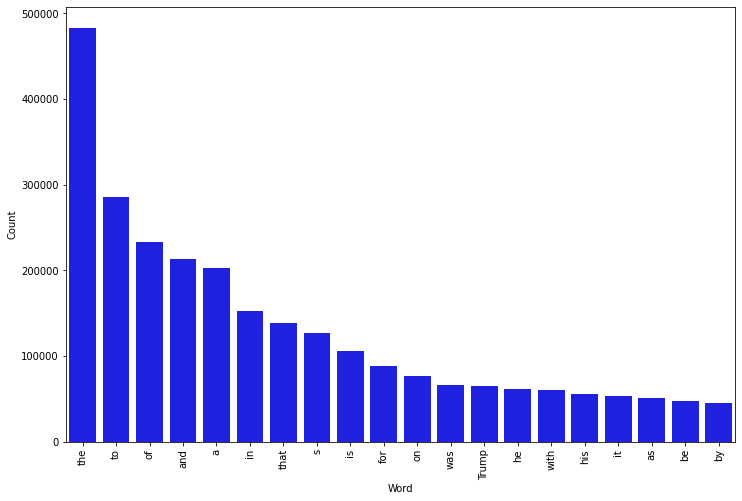

In [42]:
counter(data[data["label"] == 0], "text", 20)

<a id='parte6'></a>
# 6. Extracción de características (ó vectorización)

Para utilizar los datos textuales dentro de un modelo de predicción, debemos de analizar el texto para eliminar ciertas palabras, a este proceso se le conoce como **tokenización**. Las palabras pueden codificarse como valores de tipo entero ó de punto flotante para ser utilizadas como entradas en nuestro modelo de predicción. Analizaremos dos de estas técnicas a continuación.

## 6.1 Count Vectorizer

Este algoritmo se utiliza para convertir una colección de documentos de texto en un vector de tokens. El algoritmo es útil cuando cuando tenemos varios textos de este tipo y deseamos convertir cada palabra de cada texto en vectores.

In [43]:
vectorizer = CountVectorizer().fit(data.cleanedJoined)

In [44]:
# Guardaremos el algoritmo
pickle.dump(vectorizer, open('/content/drive/MyDrive/models/countVectorizer.pkl', 'wb'))

In [45]:
print(len(vectorizer.vocabulary_))

122996


In [46]:
newsVectorizer = vectorizer.transform(data.cleanedJoined)

## 6.2 Tf-idf 
Tf-idf es una abreviación para Term Frequency - Inverse Document Frequency.

Este algoritmo nos permite determinar las palabaras más importantes de un documento, en este caso el texto de la noticia que contiene nuestro conjunto de datos. Estas palabras deben ponderarse negativamente en importancia.

### 6.2.1 Formula del Tf-idf

$$
w_{i, j} = tf_{i, j} * \log (\frac{N}{df_{i}})
$$

Donde:

* $w_{i,j}$: peso del token $i$ del Tf-idf en el documento $j$
* $tf_{i,j}$: número de occurrencias del token $i$ dentro del documento $j$
* $df_{i}$: número de documentos que contienen el token $i$
* $N$: número total de documentos


In [47]:
tfidfTransformer = TfidfTransformer().fit(newsVectorizer)

In [48]:
# Guardaremos el algoritmo
pickle.dump(tfidfTransformer, open('/content/drive/MyDrive/models/tfidf.pkl', 'wb'))

In [49]:
newsTfidf = tfidfTransformer.transform(newsVectorizer)

In [50]:
print(newsTfidf.shape)

(44898, 122996)


<a id='parte7'></a>
# 7. Preparando los conjuntos: Entrenamiento & Prueba



In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    data.cleanedJoined, 
    data.label, 
    test_size=0.3, 
    random_state=42
)

In [52]:
print('Tamaño del conjunto de entrenamiento: {}'.format(len(X_train)))
print('Tamaño del conjunto de pruebas: {}'.format(len(X_test)))
print('Longitud del conjunto de datos: {}'.format(len(data)))

Tamaño del conjunto de entrenamiento: 31428
Tamaño del conjunto de pruebas: 13470
Longitud del conjunto de datos: 44898


<a id='parte8'></a>
# 8. Modelos de Aprendizaje Automático

## 8.1 Clasificadores del aprendizaje supervisado

Utilizaremos una de las funciones de **scikit-learn** para construir algunas matrices de confusión para los modelos que implementemos. Una matriz de confusión muestra las etiquetas adecuadas en la diagonal principal (de arriba a la izquierda a abajo a la derecha). Las otras celdas muestran las etiquetas incorrectas, a menudo denominadas falsos positivos o falsos negativos. Dependiendo de su problema, uno de estos puede ser más significativo.

Esta función de código abierto la puedes encontrar en el siguiente [link](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html).

In [53]:
"""
This function prints and plots the confusion matrix.
Normalization can be applied by setting `normalize=True`.
"""
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


### 8.1.1 Naïve Bayes

In [54]:
NBPipeline = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("tfidf", TfidfTransformer()),
    ("naiveBayes", MultinomialNB()),
])

Ajustaremos el clasificador de *Naïve Bayes* a los conjuntos de entrenamiento que genereamos anteriormente. 

In [55]:
NBPipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('naiveBayes',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [56]:
NBPredictions = NBPipeline.predict(X_test)

In [57]:
print(classification_report(NBPredictions, y_test))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      7060
           1       0.92      0.93      0.93      6410

    accuracy                           0.93     13470
   macro avg       0.93      0.93      0.93     13470
weighted avg       0.93      0.93      0.93     13470



In [58]:
score = accuracy_score(y_test, NBPredictions)
print("Accuracy: {}%".format(round(score*100, 2)))

Accuracy: 92.99%


Confusion matrix, without normalization


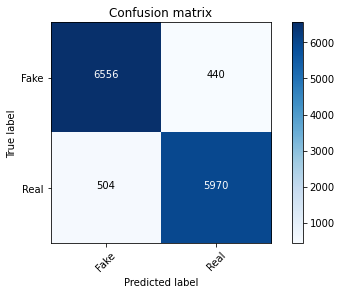

In [59]:
# Calculo de la matriz de confusion
cmNB = confusion_matrix(y_test, NBPredictions)
plot_confusion_matrix(cmNB, classes=['Fake', 'Real'])

### 8.1.2 Regresión Logística

In [60]:
logisticPipeline = Pipeline([
                             ('vectorizer', CountVectorizer()),
                             ('tfidf', TfidfTransformer()),
                             ('logisticRegression', LogisticRegression())
])

In [61]:
logisticPipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabula...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('logisticRegression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
              

In [62]:
logisticPredictions = logisticPipeline.predict(X_test)

In [63]:
print(classification_report(logisticPredictions, y_test))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      6927
           1       0.99      0.98      0.98      6543

    accuracy                           0.99     13470
   macro avg       0.99      0.98      0.99     13470
weighted avg       0.99      0.99      0.99     13470



In [64]:
score = accuracy_score(y_test, logisticPredictions)
print("Accuracy: {}%".format(round(score*100, 2)))

Accuracy: 98.51%


Confusion matrix, without normalization


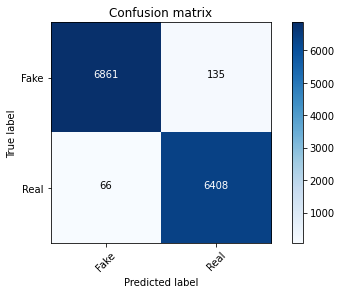

In [65]:
# Calculo de la matriz de confusion
cmLogReg = confusion_matrix(y_test, logisticPredictions)
plot_confusion_matrix(cmLogReg, classes=['Fake', 'Real'])

### 8.1.3 Clasificador Pasivo - Agresivo

In [66]:
passiveAgressive = Pipeline([
                             ('vectorizer', CountVectorizer()),
                             ('tfidf', TfidfTransformer()),
                             ('passiveAgressive', PassiveAggressiveClassifier(max_iter=50))
])

In [67]:
passiveAgressive.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabula...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('passiveAgressive',
                 PassiveAggressiveClassifier(C=1.0, average=False,
                                             class_weight=None,
                                    

In [68]:
passiveAgressivePredictions = passiveAgressive.predict(X_test)

In [69]:
print(classification_report(passiveAgressivePredictions, y_test))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6987
           1       1.00      0.99      0.99      6483

    accuracy                           0.99     13470
   macro avg       0.99      0.99      0.99     13470
weighted avg       0.99      0.99      0.99     13470



In [70]:
score = accuracy_score(y_test, passiveAgressivePredictions)
print("Accuracy: {}%".format(round(score*100, 2)))

Accuracy: 99.46%


Confusion matrix, without normalization


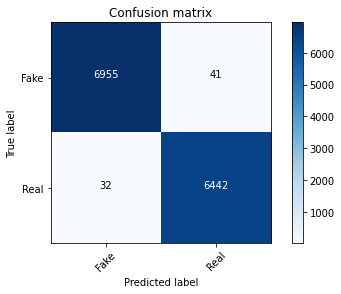

In [71]:
# Calculo de la matriz de confusion
cmPA = confusion_matrix(y_test, passiveAgressivePredictions)
plot_confusion_matrix(cmPA, classes=['Fake', 'Real'])

## 8.2 Clasificadores del aprendizaje no supervisado

### 8.2.1 Árboles de Decisión

In [72]:
DTPipeline = Pipeline([
                       ('vectorizer', CountVectorizer()),
                       ('tfidf', TfidfTransformer()),
                       ('dtree', DecisionTreeClassifier(
                           criterion = 'entropy',
                           max_depth = 20,
                           splitter = 'best',
                           random_state = 42
                       ))
])

In [73]:
DTPipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabula...
                                  sublinear_tf=False, use_idf=True)),
                ('dtree',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='entropy', max_depth=20,
                                        max_features=None, max_leaf_nodes=None,
           

In [74]:
DTPredictions = DTPipeline.predict(X_test)

In [75]:
print(classification_report(DTPredictions, y_test))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7010
           1       0.99      1.00      1.00      6460

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470



In [76]:
score = accuracy_score(y_test, DTPredictions)
print("Accuracy: {}%".format(round(score*100, 2)))

Accuracy: 99.55%


Confusion matrix, without normalization


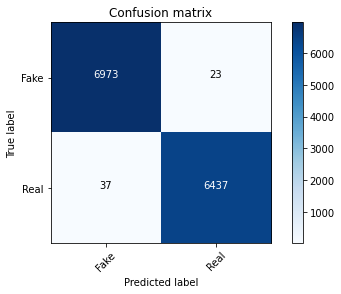

In [77]:
# Calculo de la matriz de confusion
cmDT = confusion_matrix(y_test, DTPredictions)
plot_confusion_matrix(cmDT, classes=['Fake', 'Real'])

### 8.2.2 K-NN

In [78]:
KnnPipeline = Pipeline([
                        ('vectorizer', CountVectorizer()),
                        ('tdfidf', TfidfTransformer()),
                        ('knn', KNeighborsClassifier())
])

In [79]:
KnnPipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tdfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None

In [80]:
KnnPredictions = KnnPipeline.predict(X_test)

In [81]:
print(classification_report(KnnPredictions, y_test))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86      6217
           1       0.92      0.82      0.87      7253

    accuracy                           0.86     13470
   macro avg       0.87      0.87      0.86     13470
weighted avg       0.87      0.86      0.86     13470



In [82]:
score = accuracy_score(y_test, KnnPredictions)
print("Accuracy: {}%".format(round(score*100, 2)))

Accuracy: 86.3%


Confusion matrix, without normalization


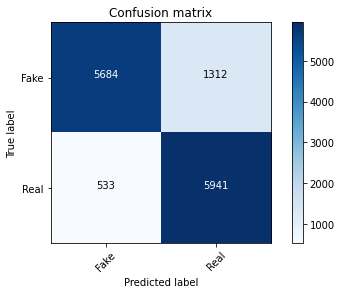

In [83]:
# Calculo de la matriz de confusion
cmKnn = confusion_matrix(y_test, KnnPredictions)
plot_confusion_matrix(cmKnn, classes=['Fake', 'Real'])

---

<a id='parte9'></a>
# 9. Recopilando los modelos

En este apartado recopilaremos los diferentes modelos de aprendizaje autómatico que hemos implementado.

## 9.1 Naïve Bayes

In [84]:
pickle.dump(NBPipeline, open('/content/drive/MyDrive/models/nbModel.pkl', 'wb'))

## 9.2 Regresión Logística

In [85]:
pickle.dump(logisticPipeline, open('/content/drive/MyDrive/models/lrModel.pkl', 'wb'))

## 9.3 Passive Agressive

In [86]:
pickle.dump(passiveAgressive, open('/content/drive/MyDrive/models/passiveAgressiveModel.pkl', 'wb'))

## 9.4 Árboles de decisión

In [87]:
pickle.dump(DTPipeline, open('/content/drive/MyDrive/models/dtModel.pkl', 'wb'))

## 9.5 K-NN

In [88]:
pickle.dump(KnnPipeline, open('/content/drive/MyDrive/models/knnModel.pkl', 'wb'))

<a id='parte10'></a>
# 10. Comparación de los modelos


|Modelo               |Accuracy|Precision|Recall|F1-Score|TP|TN|FP|FN|
|---------------------|--------|---------|------|--------|--|--|--|--|
|Naïve Bayes          |        |         |      |        |  |  |  |  |
|Regresión Logística  |        |         |      |        |  |  |  |  |
|Passive Agressive    |        |         |      |        |  |  |  |  |
|Árboles de decisión  |        |         |      |        |  |  |  |  |
|K-NN                 |        |         |      |        |  |  |  |  |


---

<a href="#top_section" class="btn btn-primary" style="color:white;" >Ir al inicio</a>